In [1]:
import mnist
import matplotlib.pyplot as plt
import numpy as np
from numpy import ndarray
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import torch.nn as nn
from sklearn.metrics import classification_report
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import os
from struct import unpack

# 1. Read MNIST from the disk

In [2]:
def read_images(filename):
    with open(filename, 'rb') as f:
        magic, num_images = unpack('>II', f.read(8))
        num_rows, num_cols = unpack('>II', f.read(8))
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, num_rows, num_cols)
    return images

def read_labels(filename):
    with open(filename, 'rb') as f:
        # both not needed for the kaggleton
        magic, num_labels = unpack('>II', f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return labels


path = 'D:/IT/Data_science/lessons/kaggle 7/digit-recognition/input'

train_images = read_images(os.path.join(path, 'train-images.idx3-ubyte'))
train_labels = read_labels(os.path.join(path, 'train-labels.idx1-ubyte'))

test_images = read_images(os.path.join(path, 't10k-images.idx3-ubyte'))
test_labels = read_labels(os.path.join(path, 't10k-labels.idx1-ubyte'))

print(f"Train Images Shape: {train_images.shape}")
print(f"Train Labels Shape: {train_labels.shape}")
print(f"Test Images Shape: {test_images.shape}")
print(f"Test Labels Shape: {test_labels.shape}")

Train Images Shape: (60000, 28, 28)
Train Labels Shape: (60000,)
Test Images Shape: (10000, 28, 28)
Test Labels Shape: (10000,)


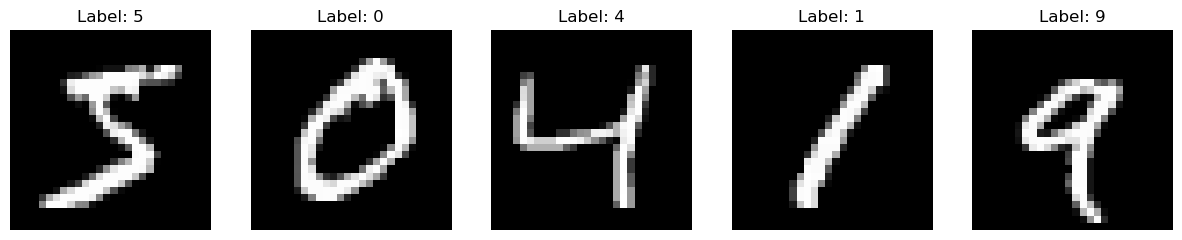

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))

for i, ax in enumerate(axes):
    ax.imshow(train_images[i], cmap='gray')
    ax.title.set_text(f'Label: {train_labels[i]}')
    ax.axis('off')
plt.show()

In [4]:
train_images[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [5]:
class MNISTDataset(Dataset):
    """MNIST dataset."""
    
    def __init__(self, images: ndarray, labels: ndarray, transform=None):
        """
        Args:
            images (numpy.ndarray): Images data.
            labels (numpy.ndarray): Labels data.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# 2. Normalization

In [6]:
def normalize(data):
    return (data / 255)

train_images = normalize(train_images)
test_images = normalize(test_images)

# 3. Datasets and Dataloaders

In [7]:
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert a numpy.ndarray to PIL Image.
    transforms.ToTensor(),  # Converts a PIL Image to a tensor.
])

# Train
train_dataset = MNISTDataset(images=train_images,
                             labels=train_labels,
                             transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Test
test_dataset = MNISTDataset(images=test_images,
                            labels=test_labels,
                            transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

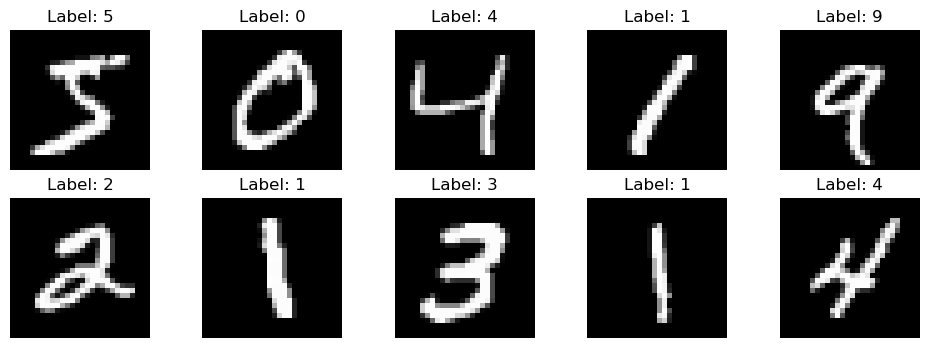

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 4))

k = 0
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(train_images[k], cmap='gray')
        ax[i, j].title.set_text(f'Label: {train_labels[k]}')
        ax[i, j].axis('off')
        k+=1
plt.show()

In [9]:
# Example of iterating over DataLoader
for images, labels in train_loader:
    print(f'Batch images shape: {images.shape}')
    print(f'Batch labels shape: {labels.shape}')
    break  # Example stops after the first batch

Batch images shape: torch.Size([64, 1, 28, 28])
Batch labels shape: torch.Size([64])


# 4. CNN

# Architecture

In [16]:
class DigitRecognition(nn.Module):
    def __init__(self, num_classes):
        super(DigitRecognition, self).__init__()
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=16,
                               kernel_size=(3,3))
                               #stride=1)

        self.pool = nn.MaxPool2d(kernel_size=(2,2))

        self.linear = nn.Linear(16*13*13, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        
        return x